Train MSE: 0.015, Test MSE: 0.016.
Train R-squared: 0.828, Test R-squared: 0.825.


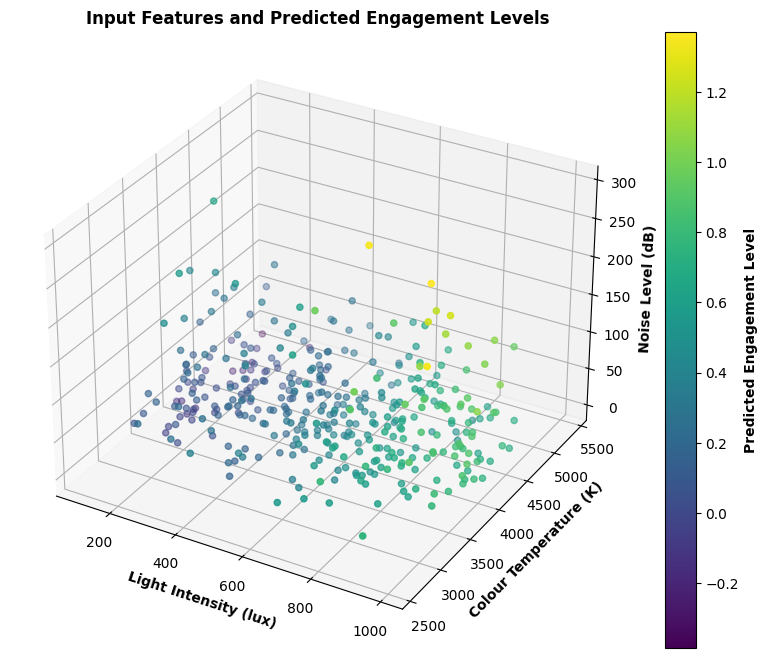

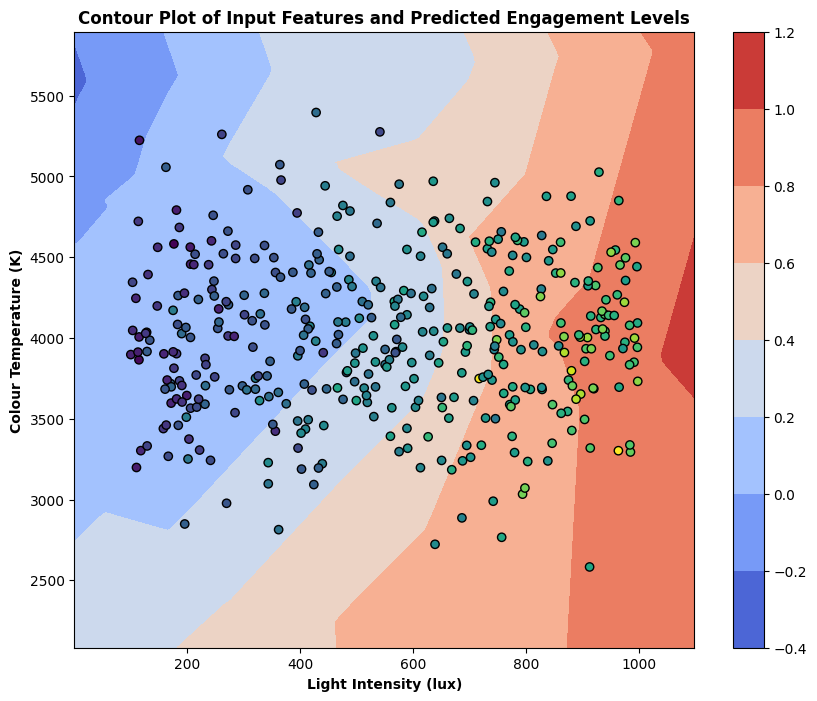

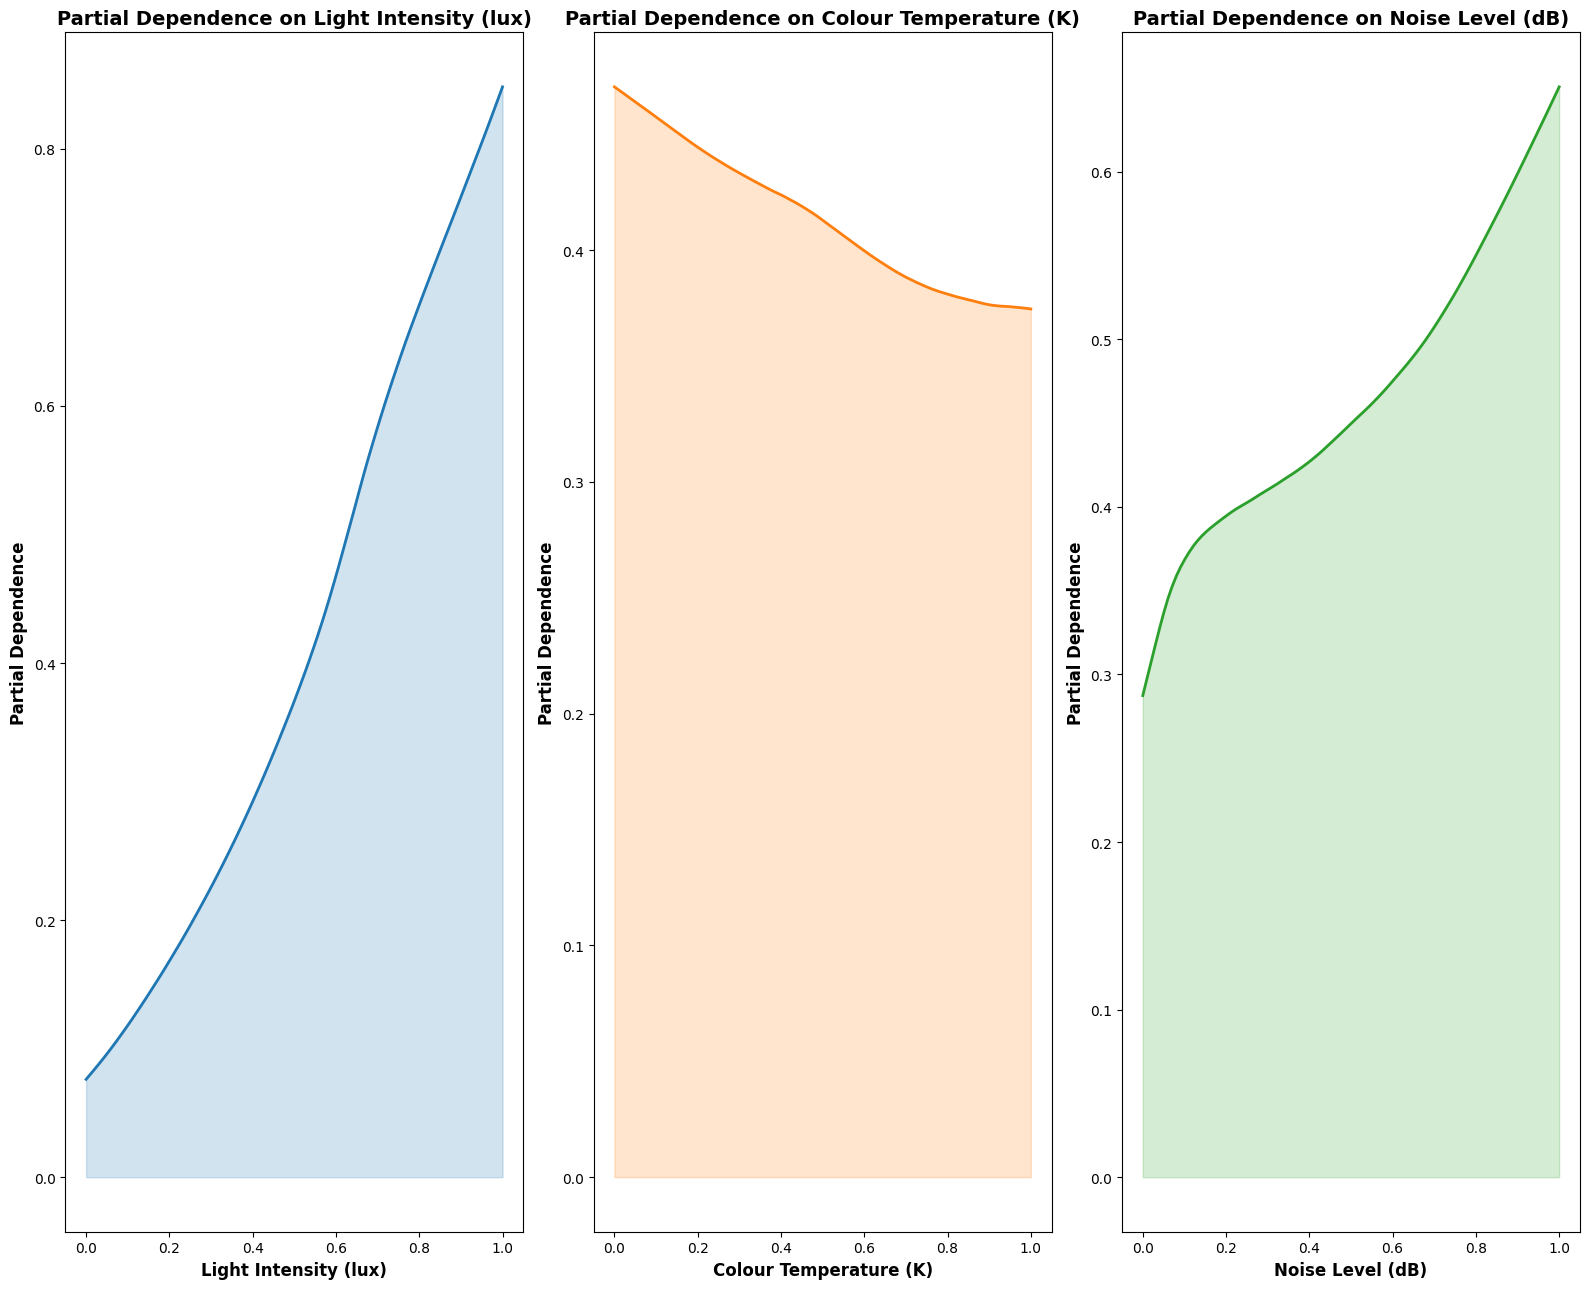

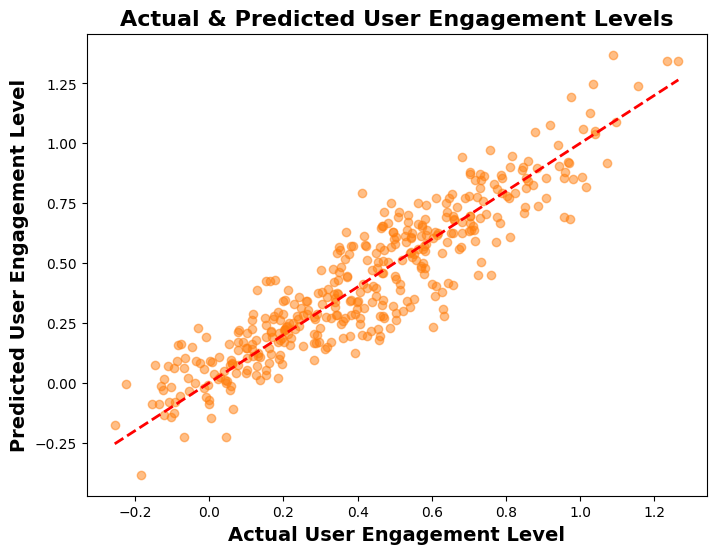

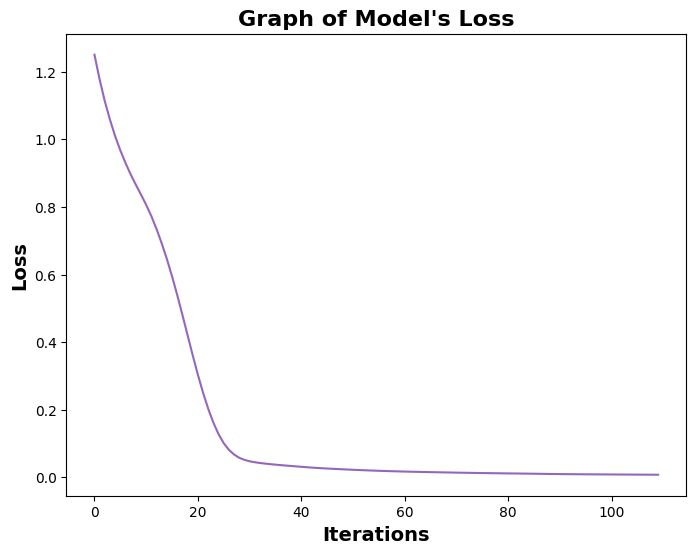

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence

# Ignore User Warning
import warnings
warnings.filterwarnings('ignore')

# Read dataset
data = pd.read_csv('main_dataset.csv')

# Split data into train and test sets
X = data[['light_intensity', 'colour_temp', 'noise_level']]
y = data['engagement_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Train the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Evaluate the model
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}.')
print(f'Train R-squared: {train_r2:.3f}, Test R-squared: {test_r2:.3f}.')

'''Visualization'''
# Plot 1: 3D Scatter Plot of Input Features and Predicted Engagement Levels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test['light_intensity'], X_test['colour_temp'], X_test['noise_level'], c=y_test_pred, cmap='viridis')
ax.set_xlabel('Light Intensity (lux)', fontweight='bold')
ax.set_ylabel('Colour Temperature (K)', fontweight='bold')
ax.set_zlabel('Noise Level (dB)', fontweight='bold')
ax.set_title('Input Features and Predicted Engagement Levels', fontweight='bold')
cb = plt.colorbar(scatter, location='right')
cb.set_label('Predicted Engagement Level', fontweight='bold')
plt.savefig('plot1.png', transparent=True, dpi = 600)
plt.show()

# Plot 2: Contour Plot of Light Intensity & Colour Temperature and Predicted Engagement Levels
x_min, x_max = X_test['light_intensity'].min() - 100, X_test['light_intensity'].max() + 100
y_min, y_max = X_test['colour_temp'].min() - 500, X_test['colour_temp'].max() + 500
X, Y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = mlp.predict(scaler.transform(np.c_[X.ravel(), Y.ravel(), np.repeat(X_test['noise_level'].mean(), X.size)]))
Z = Z.reshape(X.shape)

fig, ax = plt.subplots(figsize=(10, 8))
cp = ax.contourf(X, Y, Z, cmap='coolwarm')
plt.colorbar(cp)
ax.scatter(X_test['light_intensity'], X_test['colour_temp'], c=y_test, cmap='viridis', edgecolors='k')
ax.set_xlabel('Light Intensity (lux)', fontweight='bold')
ax.set_ylabel('Colour Temperature (K)', fontweight='bold')
ax.set_title('Contour Plot of Input Features and Predicted Engagement Levels', fontweight='bold')
plt.savefig('plot2.png', transparent=True, dpi = 600)
plt.show()

#Plot 3: Partial Dependence Plots
plt.figure(figsize=(16, 13))
features = ['light_intensity', 'colour_temp', 'noise_level']
colors = ['tab:blue', 'tab:orange', 'tab:green']
new_features = ['Light Intensity (lux)', 'Colour Temperature (K)', 'Noise Level (dB)']

for i, (new_feat,feat, color) in enumerate(zip(new_features,features, colors), start=1):
    plt.subplot(1, 3, i)
    display = partial_dependence(mlp, X_test_scaled_df, [feat], kind='average')
    x = np.linspace(0, 1, display.average.shape[1])
    y = display.average[0]
    plt.plot(x, y, color=color, linewidth=2)
    plt.fill_between(x, y, alpha=0.2, color=color)
    plt.xlabel(new_feat, fontsize=12, fontweight='bold')
    plt.ylabel('Partial Dependence', fontsize=12, fontweight='bold')
    plt.title(f'Partial Dependence on {new_feat}', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.savefig('plot3.png', transparent=True, dpi = 600)
plt.show()

# Plot 4: Actual & Predicted Engagement Levels
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, c='tab:orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual User Engagement Level', fontsize=14, fontweight='bold')
plt.ylabel('Predicted User Engagement Level', fontsize=14, fontweight='bold')
plt.title('Actual & Predicted User Engagement Levels', fontsize=16, fontweight='bold')
plt.savefig('plot4.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

# Plot 5: Model's Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(mlp.loss_curve_, 'tab:purple')
plt.xlabel('Iterations', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title("Graph of Model's Loss", fontsize=16, fontweight='bold')
plt.savefig('plot5.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()